In [1]:
import torch
import torch_geometric as pyg
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, NNConv
from torch_geometric.nn.conv import GATv2Conv
from torch_geometric.nn.models import MLP
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import BondType, HybridizationType
import os

dataset = QM9(root="./QM9")
#無向グラフの例
#edge_index = torch.tensor([[0,1,1,2],[1,0,2,1]], dtype=torch.long) # エッジの定義
#x = torch.tensor([[-1],[0],[1]], dtype=torch.float) # ノードの属性
#data = Data(x=x, edge_index=edge_index) # コンストラクタ
# Data(x=[3, 1], edge_index=[2, 4])

In [3]:
#類似度予測

def ECFPGen(smiles, radius=4, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return morgan
    
def npECFP(morgan):
    array = np.zeros(morgan.GetNumBits())
    rdkit.DataStructs.ConvertToNumpyArray(morgan, array)
    return np.nonzero(array)

In [ ]:
import pubchempy
test1 = pubchempy.get_properties(["CanonicalSMILES"], "18760-80-0", "name")
test2 = pubchempy.get_properties(["CanonicalSMILES"], "amphetamine", "name")
smiles1 = test1[0]["CanonicalSMILES"]
smiles2 = test2[0]["CanonicalSMILES"]
rdkit.DataStructs.FingerprintSimilarity(ECFPGen(smiles1), ECFPGen(smiles2))

In [102]:
np.array(list(ECFPGen(smiles1)))

array([0, 1, 0, ..., 0, 0, 0])

In [4]:
# ECFP
# 回帰の手法(https://chemrxiv.org/engage/chemrxiv/article-details/60c75208bdbb899737a3a1c2)
# MLP, kNN, KRR, SVM, RF, LightGBM, GBRT
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import random
import math
random.seed(0)

df = pd.read_csv("./qm9_dataset.csv")[:100]
ECFP = [list(ECFPGen(smiles)) for smiles in df["smiles"].values]

# 説明変数と説明変数(α)
X = [np.array(i) for i in ECFP]
Y = df["alpha"].values

# Shuffle
data = list(zip(X,Y))
random.shuffle(data)
X, Y = zip(*data)

train_X = X[:80]
train_Y = Y[:80]
test_X = X[80:]
test_Y = Y[80:]

mlp = MLPRegressor(hidden_layer_sizes=64, max_iter=10000, activation="relu", solver="adam", random_state=0)
mlp.fit(train_X,train_Y)
pred_Y = mlp.predict(test_X)
mean_squared_error(test_Y, pred_Y, squared=False)

12.711571073529566

In [5]:
train_X = X[:80]
train_Y = Y[:80]
test_X = X[80:]
test_Y = Y[80:]

import matplotlib.pyplot as plt
errors = []
for i in range(1, 10):
    hidden_layer_sizes = 2**i
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=10000, activation="relu", solver="adam", random_state=0)
    mlp.fit(train_X,train_Y)
    pred_Y = mlp.predict(test_X)
    error = mean_squared_error(test_Y, pred_Y, squared=False)
    errors.append((i,error))

/home/higuchi/mambaforge/envs/torchenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


NameError: name 'erros' is not defined

Text(0.5, 1.0, 'max_iter=10000, adam, relu')

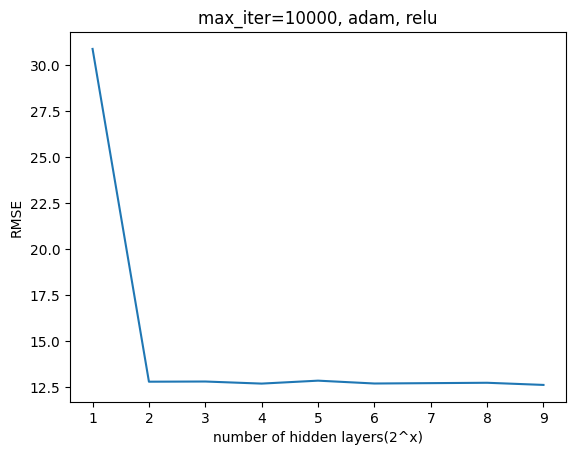

In [11]:
plt.plot([i[0] for i in errors], [i[1] for i in errors]) 
plt.xlabel("number of hidden layers(2^x)")
plt.ylabel("RMSE")
plt.title("max_iter=10000, adam, relu")

In [7]:
errors

[(1, 30.871920716036186),
 (2, 12.809592801674816),
 (3, 12.819434340759484),
 (4, 12.706582148603998),
 (5, 12.866085229371148),
 (6, 12.711571073529566),
 (7, 12.73141720389561),
 (8, 12.751472457822574),
 (9, 12.634705048505923)]

In [108]:
mean_absolute_error([1],[2])

1.0

In [81]:
ECFP

In [ ]:
# Create Dataset(For understanding)
# reference source code 
# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm9.html
# neural fingerprint on pytorch ref
# https://qiita.com/kimisyo/items/55a01e27aa03852d84e9


#RDLogger.DisableLog("rdApp.*")

# units conversion
HAR2EV = 27.211386246
KCALMOL2EV = 0.04336414
conversion = torch.tensor([
1., 1., HAR2EV, HAR2EV, HAR2EV, 1., HAR2EV, HAR2EV, HAR2EV, HAR2EV, HAR2EV,
1., KCALMOL2EV, KCALMOL2EV, KCALMOL2EV, KCALMOL2EV, 1., 1., 1.
])

atomrefs = {
    6: [0., 0., 0., 0., 0.],
    7: [
        -13.61312172, -1029.86312267, -1485.30251237, -2042.61123593,
        -2713.48485589
    ],
    8: [
        -13.5745904, -1029.82456413, -1485.26398105, -2042.5727046,
        -2713.44632457
    ],
    9: [
        -13.54887564, -1029.79887659, -1485.2382935, -2042.54701705,
        -2713.42063702
    ],
    10: [
        -13.90303183, -1030.25891228, -1485.71166277, -2043.01812778,
        -2713.88796536
    ],
    11: [0., 0., 0., 0., 0.],
}

class MyFirstDataset(pyg.data.Dataset):
    def __init__(self, root="./MyFirstDataset", transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def processed_file_names(self):
        return "qm9.pt"

    def process(self):
        types = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}
        bonds = {BondType.SINGLE: 0, BondType.DOUBLE: 1, BondType.TRIPLE: 2, BondType.AROMATIC: 3}
        
        # グラフの特徴量
        self.data = pd.read_csv("qm9_dataset.csv")
            # 列の並べ替え(reindex)
        self.data = self.data.reindex(index=["mol_id", "smiles", "alpha", "homo", "lumo", "gap", "r2", "zpve", "u0", "u298", "h298", "g298", "cv", "u0_atom", "u298_atom", "h298_atom", "g298_atom", "A", "B", "C"])
        
        for name, i in df.iterrows():
            target = [float(x) for x in i.values[2:]]
            target = torch.tensor(target, dtype=torch.float)
            target = torch.cat([target[:, 3:], target[:, 3:]], dim=0) # ?
            target = target * conversion.view(1, -1)

        for index, mol in self.data.iterrows():
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            N = mol_obj.GetNumAtoms()
            conf = mol.GetConformer()
            pos = conf.GetPositions()
            pos = torch.tensor(pos, dtype=torch.float)

            type_idx = atomic_number = aromatic = sp = sp2 = sp3 = num_hs = [], [], [], [], [], [], []
            for atom in mol_obj.GetAtoms():
                type_idx.append(types[atom.GetSymbol()])
                atomic_number.append(atom.GetAtomicNum())
                if atom.GetIsAromatic():
                    aromatic.append(1)
                else:
                    aromatic.append(0)
                hybridization = atom.GetHybridization()
                sp.append(1 if hybridization == HybridizationType.SP else 0)
                sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
                sp3.append(1 if hybridization == HybridizationType.SP3 else 0)
            z = torch.tensor(atomic_number, dtype=torch.long)
            
            # edge index
            row, col, edge_type = [], [], []
            for bond in mol_obj.GetBonds():
                start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                row += [start, end]
                col += [end, start]
                edge_type += 2 * [bonds[bond.GetBondType()]]
            
            edge_index = torch.tensor([row, col], dtype=torch.long)
            edge_type = torch.tensor(edge_type, dtype=torch.long)
            edge_attr = one_hot(edge_type, num_classes=len(bonds))

            perm = (edge_index[0] * N + edge_index[1]).argsort()
            edge_index = edge_index[:, perm]
            edge_type = edge_type[perm]
            edge_attr = edge_attr[perm]

            row, col = edge_index
            hs = (z == 1).to(torch.float)
            num_hs = scatter(hs[row], col, dim_size=N, reduce='sum').tolist()
            # types: qm9に含まれる原子の一覧(H,C,N,O,F)。num_classesは原子の種類の数
            # x1:原子記号のリスト
            x1 = one_hot(torch.tensor(type_idx), num_classes=len(types))
            
            # node features: 原子番号、芳香性、混成の有無(sp,sp2,sp3)、水素の数
            x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, num_hs],
                              dtype=torch.float).t().contiguous()
            # x1,x2を結合
            x = torch.cat([x1, x2], dim=-1)
            #グラフ特徴量
            y = target[i].unsqueeze(0)

            # node features
            node_features = self._get_node_features(mol_obj)
            # edge features
            edge_features = self._get_edge_features(mol_obj)
            # edge inde
            edge_index = self._get_adjacency_info(mol_obj)
            # label
            label = self.__get__labels(mol["alpha"])
            # create dataset
            data = pyg.Data(x=node_features,
                            edge_index=edge_index,
                            edge_attr=edge_features,
                            y=label,
                            smiles=mol["smiles"])
            torch.save(Data, os.path.join(self.processed_dir, f"data_{index}.pt"))
    
    def _get_node_features(self, mol):
        for atom in mol.GetAtoms():
            node_features = []
            node_features.append(atom.GetAtomicNum())
            node_features.append(atom.GetDegree())
            node_features.append(GetFormalCharge())


    


    


In [ ]:
df 

In [ ]:
for name, i in df.iterrows():
    print(i.values)

In [ ]:
df


In [ ]:
data = dataset[0]
data

In [ ]:
[0,1]*4

In [ ]:
for idx, mol in df.iterrows():
    print(mol)

https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html

QM9の属性

x:ノードの特徴量(原子数×特徴量数=11)

y:ラベル(ラベル数)

z:原子番号(原子数)

edge_attr:エッジ特徴量=結合次数(エッジ数×結合次数)

edge_index:エッジリスト(2×エッジ数)

pos:3Dグリッドでの各原子の位置(原子数×3)

正則化の手法
・L1正則化(重み減衰)
・L2正則化(重み減衰)
・Dropout
・ラベル平滑化
・バッチ正則化
・

In [ ]:
#https://www.graphcore.ai/posts/getting-started-with-pytorch-geometric-pyg-on-graphcore-ipus

# GCN
#NNでは64層くらい使ってる場合もある
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv1 = GCNConv(dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 32)
        self.linear1 = nn.Linear(16,1)
        self.out = nn.Linear(32, 1)
        #self.conv3 = GCNConv(32, dataset.num_classes) #num_classes:ラベルの数
    #バッチノルム(正則化)
    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        # Dropout:一定割合のノードを不活性化(0になる)させ、過学習を緩和する。pはゼロになるノードの確率で、0.5がデフォルト。
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch_geometric.nn.global_add_pool(x, batch) #これが必要やった
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        return x

class GCN_N(torch.nn.Module):
    def __init__(self, layer:int, dim=32):
        super().__init__()
        self.layer = layer
        self.dim = dim
        self.conv1 = GCNConv(dataset.num_node_features, self.dim, improved=True)
        self.convn = GCNConv(self.dim, self.dim, improved=True)
        self.out = pyg.nn.Linear(self.dim, 1)

    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        for i in range(2, self.layer + 1):
            x = self.convn(x, edge_index)
            x = F.relu(x)
        x = pyg.nn.global_add_pool(x, batch) 
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        return x

class GATv2_N(torch.nn.Module):
    def __init__(self, layer:int, dim=32):
        super().__init__()
        self.layer = layer
        self.dim = dim
        self.conv1 = GATv2Conv(dataset.num_node_features, self.dim)
        self.convn = GATv2Conv(self.dim, self.dim)
        self.out = pyg.nn.Linear(self.dim, 1)

    def forward(self, data):
        x, batch, edge_index, edge_attr = data.x, data.batch, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        for i in range(2, self.layer + 1):
            x = self.convn(x, edge_index)
            x = F.relu(x)
        x = pyg.nn.global_add_pool(x, batch) 
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        return x

In [ ]:
GATv2Conv

In [ ]:
class GNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_net = torch.nn.Sequential(nn.Linear(dataset.num_edge_features, 32),
                                            nn.ReLU(),
                                            nn.Linear(32, dataset.num_node_features*32))
        self.conv2_net = torch.nn.Sequential(nn.Linear(dataset.num_edge_features, 32),
                                            nn.ReLU(),
                                            nn.Linear(32, 32*16))        
        self.conv1 = NNConv(dataset.num_node_features, 32, self.conv1_net)
        self.conv2 = NNConv(32, 16, self.conv2_net)
        self.linear1 = torch.nn.Linear(16, 32)
        self.out = nn.Linear(32,1)
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = torch_geometric.nn.global_add_pool(x, batch)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.out(x)
        return x

In [ ]:
# ECFP
# https://qiita.com/kimisyo/items/55a01e27aa03852d84e9
# https://pubs.acs.org/doi/10.1021/acsomega.1c01266
# https://pubs.acs.org/doi/10.1021/acs.jcim.0c01208

import pandas as pd
df = pd.read_csv("./qm9_dataset.csv")

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import numpy as np

def ECFPGen(smiles, radius=3, nBits=12):
    mol = Chem.MolFromSmiles(smiles)
    bit_morgan1 = {}
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bit_morgan1)
    bit1 = list(fp1)
    return bit1

df["ECFP"] =  [ECFPGen(smiles, radius=2, nBits=2048) for smiles in df["smiles"]]

In [ ]:
# dataset作成
polar = df["alpha"]
ECFP = df["ECFP"]


In [ ]:
df.describe()

In [ ]:
if [0,0,0]:
    print("a")

In [ ]:
#dipole予測　＋　ECFPのみ　＋　ECFP,dipole
#層とdimentionを増やすとどう変わるか
#NN:３層以上 層を増やすより隠れ層を増やすほうが良さそう

In [ ]:
#データの分割(total: 130831)
num_train, num_val = int(len(dataset)*0.6), int(len(dataset)*0.2)
num_test = len(dataset) - (num_train + num_val)
batch_size = 32

# 乱数の固定
device = torch.device("cpu")
seed = 0
pyg.seed_everything(seed=seed)
"""
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
"""
train_set, valid_set, test_set = random_split(dataset, [num_train, num_val, num_test])

#Dataloaderの生成
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=pyg.seed_everything(seed))
valid_loader = DataLoader(valid_set, batch_size=batch_size, worker_init_fn=pyg.seed_everything(seed))
test_loader = DataLoader(test_set, batch_size=batch_size, worker_init_fn=pyg.seed_everything(seed))

layer = 2
dim = 32
model = GCN_N(layer=layer, dim=dim) 
# 損失関数
criterion = F.mse_loss
# Optimizerの初期化
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
#optimizer = torch.optim.Adam(params=lr=0.01, weight_decay=5e-4)



In [ ]:
GATv2Conv()

In [ ]:
# 学習したいラベルのインデックス位置
target_idx = 1
loss_two_50 = []
start = time.time() #時間計測開始
for epoch in range(50):
    # train
    model.train()
    train_loss = 0
    total_graphs = 0
    for batch in train_loader:
        batch = batch.to("cpu")
        optimizer.zero_grad()
        prediction = model(batch)
        loss = torch.sqrt(criterion(prediction, batch.y[:, target_idx].unsqueeze(1)))
        loss.backward()
        train_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    train_loss /=  len(train_loader) #損失の平均(batchあたり)

    # validation
    model.eval()
    valid_loss = 0
    total_graphs = 0
    with torch.inference_mode(): # 自動微分無効。torch.no_grad()よりさらに高速化
        for batch in valid_loader:
            prediction = model(batch)
            loss = torch.sqrt(criterion(prediction, batch.y[:, target_idx].unsqueeze(1)))
            valid_loss += loss.item()
            total_graphs += batch.num_graphs
    valid_loss /= len(valid_loader)

    print(f"Epoch {epoch+1} | train_loss:{train_loss}, valid_loss:{valid_loss}")
    #loss_three_50.append({"Epoch":epoch + 1 , "train_loss":train_loss, "valid_loss":valid_loss})
used_time = time.time() - start
"""
loss_two_50.append(
    {
        "model": "GCN",
        "layer": layer,
        "dim": dim,
        "batch_size": 32,
        "loss": "RMSE",
        "lr": 0.01,
        "decay": 5e-4,
        "seed": seed,
        "data_split":[
            0.6,
            0.6,
            0.2
        ],
        "time": round(used_time, 4)
    }
)
"""

In [ ]:
loss_three_50

In [ ]:
loss_two_50 = loss_three_50[51:]

loss_two_50.append(
    {
        "model": "GCN",
        "layer": layer,
        "dim": dim,
        "batch_size": 32,
        "loss": "RMSE",
        "lr": 0.01,
        "decay": 5e-4,
        "seed": seed,
        "data_split":[
            0.6,
            0.6,
            0.2
        ],
        "time": round(used_time, 4)
    }
)

In [ ]:
import json
with open("./loss_two_50.json", "a") as f:
    json.dump(loss_two_50, f, indent=4)

In [ ]:
with open("./loss_two_50.json", "r") as f:
    two = json.load(f)
dim16 = two[1][:-1]
dim32 = two[0][:-1]

In [ ]:
#2層
epoch = [i for i in range(1, 51)] 

plt.subplot(121)
plt.plot(epoch, [i["train_loss"] for i in dim16])
plt.plot(epoch, [i["valid_loss"] for i in dim16])
plt.title("dim=16")
plt.ylim(0,14)
plt.subplot(122)
plt.plot(epoch, [i["train_loss"] for i in dim32])
plt.plot(epoch, [i["valid_loss"] for i in dim32])
plt.title("dim=32")
plt.ylim(0,14)

In [ ]:
dim16

In [ ]:
# お前はもう必要ない
import re
def parser(text):
    text = text.split("\n")
    loss = [{"train_loss":re.sub("train_loss:", "", i.split("| ")[1].split(",")[0]), "valid_loss":re.sub(" valid_loss:", "", i.split("| ")[1].split(",")[1])}for i in text if i]
    train_loss = [float(i["train_loss"]) for i in loss]
    valid_loss = [float(i["valid_loss"]) for i in loss]
    return np.array([train_loss, valid_loss])
loss_two = parser(two_layers)
loss_three = parser(theree_layers)

In [ ]:
# 2層
import matplotlib.pyplot as plt
import math
epoch = [i for i in range(1, len(loss_two[0]) + 1)]
plt.subplot(1,2,1) 
loss_two = np.log(loss_two)
plt.plot(epoch, loss_two[0])
plt.subplot(1,2,2)
plt.plot(epoch, loss_two[1])

In [ ]:
# 3層
import matplotlib.pyplot as plt
epoch = [i for i in range(1, len(loss_three[0]) + 1)]
loss_three = np.log(loss_three)
plt.subplot(1,2,1)
plt.plot(epoch, loss_three[0])
plt.subplot(1,2,2)
plt.plot(epoch, loss_three[1])

In [ ]:
model.eval() # 評価開始
predictions = []
real = []
for batch in test_loader:
    output = model(batch.to("cpu"))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:,target_idx].detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

plt.scatter(real, predictions)
plt.ylabel('Predicted')
plt.xlabel('real')
plt.show()


Creating Your Own Datasets

https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

https://qiita.com/maskot1977/items/4aa6322459eb3a78955f


Datasets

https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html


TORCH.NN.FUNCTIONAL

https://pytorch.org/docs/stable/nn.functional.html


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

# エタンのグラフ構造の作成
mol = Chem.MolFromSmiles("CC")
mol = Chem.AddHs(mol)
atoms = mol.GetAtoms()
bonds = mol.GetBonds()
bonds[0].GetEndAtomIdx()

edge_list = []
for bond in bonds:
    edge_list.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
    edge_list.append([bond.GetEndAtomIdx(),bond.GetBeginAtomIdx()])
edge_index = torch.tensor(edge_list) #エッジのリスト作成
x = torch.tensor([[atom.GetAtomicNum()] for atom in atoms]) # 原子番号

edge_attr = []
for bond in bonds:
    edge_attr.append([])
data = Data(x=x, edge_index=edge_index.t().contiguous())
data



In [ ]:
# グラフ構造の可視化
import networkx
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx
from IPython.display import SVG, display
data = dataset[4921]
nxg = to_networkx(data)

pagerank = networkx.pagerank(nxg) #pagerankはノードの中心性(重要性の指標)
pagerank_max = np.array(list(pagerank.values())).max()

#可視化する時のノード位置
draw_position = networkx.spring_layout(nxg,seed=0)

# 色指定
color_map = plt.get_cmap("tab10")
labels = data.x.numpy()
colors = [color_map(i) for i in labels]

svg = SVG(networkx.nx_agraph.to_agraph(nxg).draw(prog='fdp', format='svg'))
display(svg)

In [ ]:
# 学習したいラベルのインデックス位置
target_idx = 1

for epoch in range(50):
    model.train() #訓練モード
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    model.eval()
    for batch in valid_loader:
        output = model(batch)
        loss = criterion(output,batch.y[:, target_idx].unsqueeze(1)) #平方根で比較
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    
    val_avg_loss = val_loss / total_graphs
    print(f"Epochs: {i} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")
    